# Imports

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50, resnet101, resnet152
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet50_Weights, ResNet101_Weights, ResNet152_Weights
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")


# Enhanced ResNet Model
We have introduced modifications to the standard ResNet architecture, such as stochastic depth and dynamic layer scaling, to improve generalization and efficiency.

In [71]:
class ControlledStochasticDepthResNet(nn.Module):
    def __init__(self, base_model, thinning_factor=0.5):
        super().__init__()
        self.base_model = base_model
        self.thinning_factor = thinning_factor  # Factor to reduce the complexity uniformly.

        # Reduce the number of channels in each convolutional layer by the thinning factor
        for name, module in self.base_model.named_modules():
            if isinstance(module, nn.Conv2d):
                out_channels = int(module.out_channels * self.thinning_factor)
                in_channels = int(module.in_channels * self.thinning_factor)
                kernel_size = module.kernel_size
                stride = module.stride
                padding = module.padding
                module.out_channels = out_channels
                module.in_channels = in_channels
                module.kernel_size = kernel_size
                module.stride = stride
                module.padding = padding

    def forward(self, x):
        x = self.base_model(x)
        return x

def create_resnet(model_name, num_classes=200):
    if model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
    elif model_name == 'resnet101':
        weights = ResNet101_Weights.DEFAULT
        model = resnet101(weights=weights)
    elif model_name == 'resnet152':
        weights = ResNet152_Weights.DEFAULT
        model = resnet152(weights=weights)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'resnet101', or 'resnet152'.")

    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    enhanced_model = ControlledStochasticDepthResNet(model, thinning_factor=0.8)
    return enhanced_model

# Model Training Function
This function will handle the training of the ResNet model, including implementing a dynamic adjustment of layers based on training needs to optimize computational resources.

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

import time

def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs for training.")
        model = nn.DataParallel(model)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    test_predictions = []
    test_labels = []
    inference_times = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, unit='batch', disable=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        epoch_train_loss = train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        train_acc = calculate_accuracy(model, train_loader, device)
        train_accuracies.append(train_acc)

        # Evaluation on the test set
        model.eval()
        test_loss = 0.0
        test_preds = []
        test_lbls = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                start_time = time.time()
                outputs = model(inputs)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_lbls.extend(labels.cpu().numpy())

            test_predictions.append(test_preds)
            test_labels.append(test_lbls)

        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)

        test_acc = accuracy_score(test_lbls, test_preds)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    test_predictions = [item for sublist in test_predictions for item in sublist]
    test_labels = [item for sublist in test_labels for item in sublist]

    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    cm = confusion_matrix(test_labels, test_predictions)

    return train_losses, train_accuracies, test_losses, test_accuracies, test_predictions, test_labels, accuracy, precision, recall, f1, cm, inference_times


def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Data Preparation
Loading and transforming the ImageNet dataset

In [73]:
import os

def load_data(dataset_name, data_dir=None):
    if dataset_name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

    elif dataset_name == 'imagenet':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        if data_dir is None:
            raise ValueError("Please provide the path to the ImageNet dataset directory.")
        train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
        test_dataset = ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
        trainloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        testloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    else:
        raise ValueError("Invalid dataset name. Choose from 'cifar10' or 'imagenet'.")

    return trainloader, testloader

In [5]:
# # !pip install torchviz
# # !pip install torchsummary
# !pip install torchinfo

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# from torchviz import make_dot
# from torchsummary import summary

# # Visualization for training and validation curves
# def plot_curves(epochs, train_losses, val_losses, train_accs, val_accs):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, train_losses, label='Train Loss')
#     plt.plot(epochs, val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, train_accs, label='Train Accuracy')
#     plt.plot(epochs, val_accs, label='Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

# # Confusion matrix visualization
# def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.figure(figsize=(10, 8))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         cm = np.round(cm, 2)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

# # Model architecture visualization
# def visualize_model(model, input_size=(3, 224, 224)):
#     dummy_input = torch.randn(input_size)
#     model_vis = make_dot(model(dummy_input), params=dict(model.named_parameters()))
#     model_vis.render("model_architecture", format="png")

# # Model summary

# def print_model_summary(model, input_size=(3, 224, 224), batch_size=-1):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     summary(model, input_size=input_size, batch_size=batch_size, device=device)

# Main Execution

In [39]:
import matplotlib.pyplot as plt

def plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies, model_name="", dataset_name=""):
    epochs = range(1, len(train_losses) + 1)

    # Plotting training metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, test_losses, 'g', label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set ticks at integer epochs
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'm', label='Test accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set ticks at integer epochs
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot
    if model_name and dataset_name:
        filename = f"{model_name}_{dataset_name}_losses_accuracies_plot.png"
        plt.savefig(filename, dpi=300)
        print(f"Plot saved as {filename}")
    else:
        plt.savefig("losses_accuracies_plot.png", dpi=300)
        print("Plot saved as losses_accuracies_plot.png")
        
    plt.show()


In [ ]:


model_name = 'resnet50'  # Choose from 'resnet50', 'resnet101', or 'resnet152'
dataset_name = 'imagenet'  # Choose from 'cifar10' or 'imagenet'
# data_dir = None  # Path to the ImageNet dataset directory (required if dataset_name is 'imagenet')
data_dir = "/kaggle/input/imagenet-tiny/tiny-imagenet-200"
train_loader, test_loader = load_data(dataset_name, data_dir)
model = create_resnet(model_name, num_classes=10 if dataset_name == 'cifar10' else 200)
num_epochs = 10
train_losses, train_accuracies, test_losses, test_accuracies, test_predictions, test_labels, accuracy, precision, recall, f1, cm, inference_times = train_model(model, train_loader, test_loader, num_epochs=num_epochs)



100%|██████████| 3125/3125 [15:29<00:00,  3.36batch/s, loss=2.8] 


Epoch [1/10], Train Loss: 3.1841, Train Accuracy: 0.4503, Test Loss: 10.8858, Test Accuracy: 0.0037


 99%|█████████▉| 3105/3125 [12:24<00:04,  4.06batch/s, loss=2.05] 

Epoch [2/10], Train Loss: 2.1273, Train Accuracy: 0.5978, Test Loss: 12.2197, Test Accuracy: 0.0049


100%|██████████| 3125/3125 [13:13<00:00,  3.94batch/s, loss=1.43] 


Epoch [3/10], Train Loss: 1.6491, Train Accuracy: 0.6851, Test Loss: 12.7967, Test Accuracy: 0.0046


100%|██████████| 3125/3125 [12:46<00:00,  4.08batch/s, loss=1.02] 


Epoch [4/10], Train Loss: 1.2409, Train Accuracy: 0.7933, Test Loss: 13.6167, Test Accuracy: 0.0068


100%|██████████| 3125/3125 [12:34<00:00,  4.14batch/s, loss=0.415]


Epoch [5/10], Train Loss: 0.8642, Train Accuracy: 0.8741, Test Loss: 15.2409, Test Accuracy: 0.0058


100%|██████████| 3125/3125 [12:28<00:00,  4.17batch/s, loss=0.593]


Epoch [6/10], Train Loss: 0.5338, Train Accuracy: 0.9276, Test Loss: 17.4873, Test Accuracy: 0.0042


100%|██████████| 3125/3125 [13:01<00:00,  4.00batch/s, loss=0.514] 


Epoch [7/10], Train Loss: 0.3279, Train Accuracy: 0.9519, Test Loss: 16.8432, Test Accuracy: 0.0064


 20%|█▉        | 613/3125 [02:28<10:26,  4.01batch/s, loss=0.157] 

In [52]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)

# Calculate precision
precision = precision_score(test_labels, test_predictions, average='weighted')

# Calculate recall
recall = recall_score(test_labels, test_predictions, average='weighted')

# Calculate F1 score
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)




In [ ]:
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))


In [56]:
print(f"Model Name: {model_name} modified")
print(f"Dataset Name: {dataset_name}")
print("Number of epochs: 10")

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))

average_inference_time = sum(inference_times) / len(inference_times)
print("Average Inference Time:", round(average_inference_time, 5))


Model Name: resnet152 modified
Dataset Name: cifar10
Number of epochs: 10
Accuracy: 0.799
Precision: 0.799
Recall: 0.799
F1 Score: 0.799
Average Inference Time: 0.02516


resnet152_cifar10__confusion_matrix.png


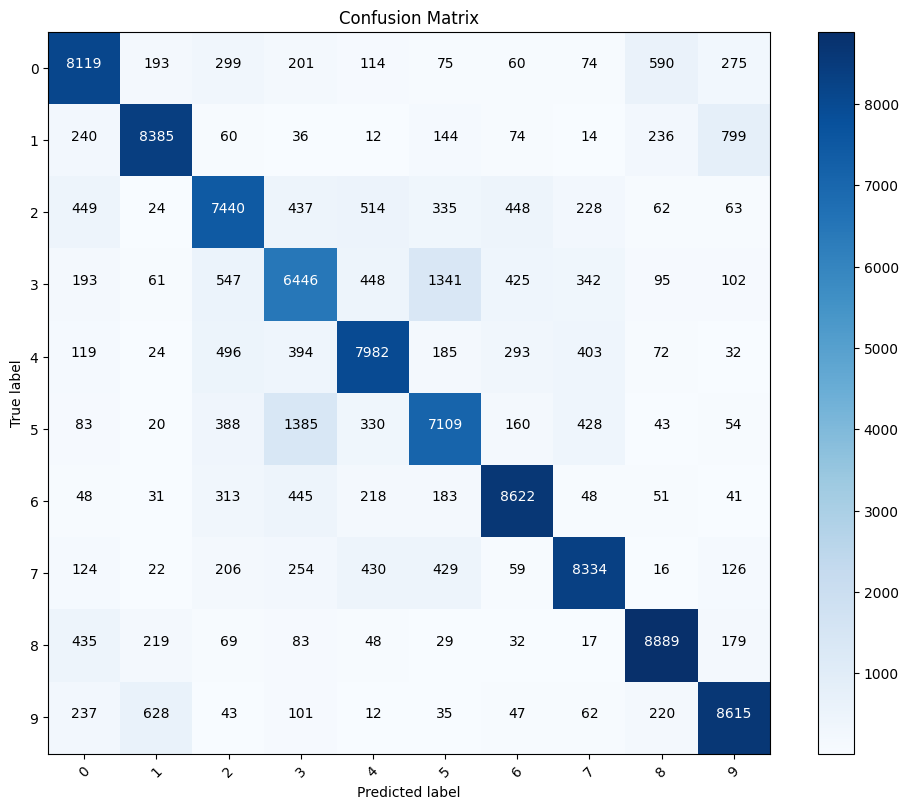

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Assuming cm is your confusion matrix
# cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
num_classes = cm.shape[0]
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes), rotation=45)
plt.yticks(tick_marks, range(num_classes))

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Save the plot with higher resolution
name = model_name + "_" + dataset_name + "_"+ "_confusion_matrix.png"
print(name)
plt.savefig(name, dpi=300)  # Adjust DPI for higher resolution
plt.show()


In [46]:
test_accuracies

[0.5033,
 0.6417,
 0.6015,
 0.7577,
 0.7783,
 0.7842,
 0.8002,
 0.8117,
 0.8167,
 0.8158]

Plot saved as resnet152_cifar10_losses_accuracies_plot.png


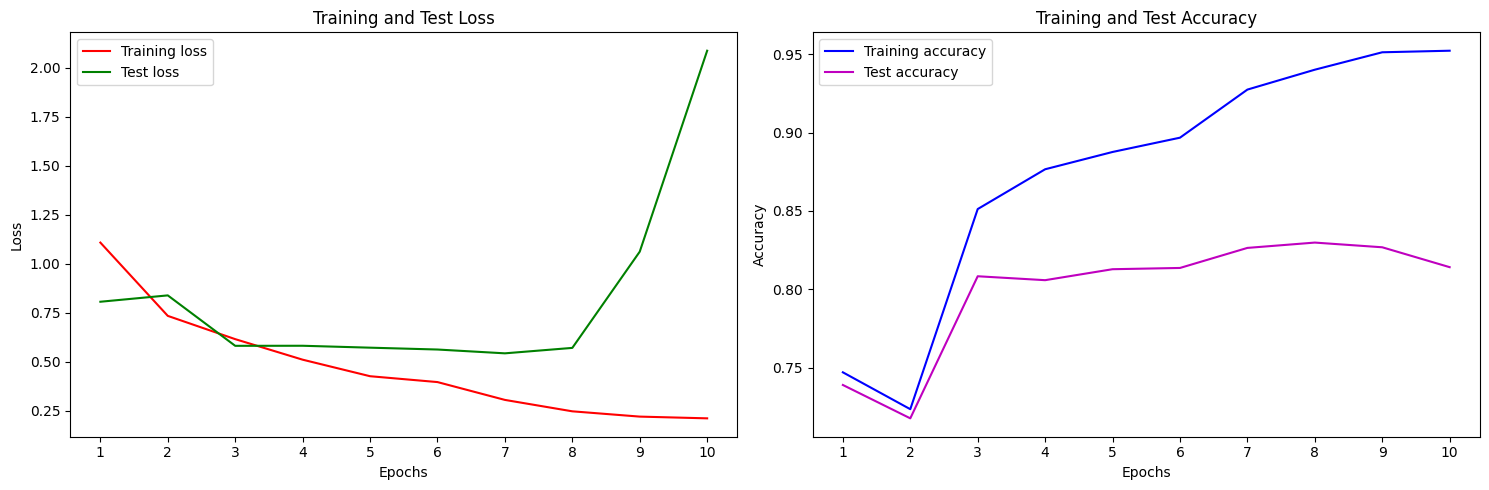

In [59]:
plot_losses_accuracies(train_losses, train_accuracies, test_losses, test_accuracies, model_name, dataset_name)
